In [6]:
#PIDミュレーション Ver 0.1 (暫定版)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm

In [7]:
"""
def rk4(func, t, h, x, *p)
4次のルンゲ・クッタ法を一回分計算する関数
    引数リスト
    func:導関数
    t：現在時刻を表す変数
    h：刻み幅
    x：出力変数（求めたい値）
    *p:引数の数が可変する事に対応する、その他の必要変数
※この関数では時刻は更新されないため、これとは別に時間更新をする必要があります。

導関数の書き方
def func(t, x, *state):
    func:自分で好きな関数名をつけられます
    t:時刻変数(変数の文字はtで無くても良い) 
    x:出力変数(変数の文字はxで無くても良い)
    *state:その他の必要変数(引数の数は可変可能))
#関数サンプル
def vdot(t, x, *state):
    s1=state[0]
    s2=state[1]
    return t+x+s1+s2
    
"""

def rk4(func, t, h, x, *p):
    #print(x)
    k1=h*func(t, x, *p)
    k2=h*func(t+0.5*h, x+0.5*k1, *p)
    k3=h*func(t+0.5*h, x+0.5*k2, *p) 
    k4=h*func(t+h, x+k3, *p)
    x=x+(k1 + 2*k2 + 2*k3 + k4)/6
    return x


In [8]:
#位置型PID制御の実装例
class pid:
    def __init__(self, kp, ti, td,limit_upper=100.0,limit_lower=-100.0,limitter=False):
        self.Sum=0.0
        self.olderr=0.0
        self.oldtime=0.0
        self.limit_upper= limit_upper
        self.limit_lower= limit_lower
        self.limitterFlag=True
        self.Kp=kp
        self.Ti=ti
        self.Td=td
        self.u=0.0
    
    def controller(self, y, ref, t):
        err=ref-y
        period=t-self.oldtime
        self.Sum=self.Sum+err*period
        #print(period)
        if period==0.0:
            errdot=0.0
        else:
            errdot=(err-self.olderr)/period
        
        self.u=self.Kp*(err + self.Sum/self.Ti + self.Td*errdot)
        #リミッター
        if self.limitterFlag==True:
            if self.u>self.limit_upper:
                self.u=self.limit_upper
            elif self.u<self.limit_lower:
                self.u=self.limit_lower
        
        self.oldtime=t
        self.olderr=err
    
        return self.u

In [ ]:
class vpid:
    def __init__(self, kp, ti, td,limit_upper=100.0,limit_lower=-100.0,limitter=False):
        self.Sum=0.0
        self.olderr1=0.0
        self.olderr2=0.0
        self.oldtime=0.0
        self.limit_upper= limit_upper
        self.limit_lower= limit_lower
        self.limitterFlag=True
        self.Kp=kp
        self.Ti=ti
        self.Td=td
        self.u=0.0
    
    def controller(self, y, ref, t):
        err=ref-y
        period=t-self.oldtime
        self.Sum=self.Sum+err*period
        #errdot=(err-self.olderr)/period
        if period==0.0:
            self.u=self.u\
                + self.Kp*(err-self.olderr1 + period*err/self.Ti)
        else:
            self.u=self.u\
                + self.Kp*(err-self.olderr1 + period*err/self.Ti + self.Td*(err-2*self.olderr1+self.olderr2)/period)
 
        #リミッター
        if self.limitterFlag==True:
            if self.u>self.limit_upper:
                self.u=self.limit_upper
            elif self.u<self.limit_lower:
                self.u=self.limit_lower
        
        self.oldtime=t
        
        self.olderr2=self.olderr1
        self.olderr1=err
    
        return self.u

  0%|          | 0/3000 [00:00<?, ?it/s]

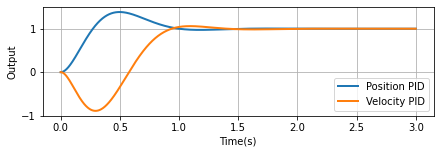

In [40]:
def xdot(t,x,u): 
    #
    # vdot = -2v -x +u
    # xdot =   v
    #
    vdot=-2*x[0]-x[1]+u
    xdot=x[0]
    return np.array([vdot,xdot])


fintime=3
h=1e-3

Kp= 66.8205
Ti=  0.4000
Td=  0.1383
pidcon=pid(Kp,Ti,Td)
vpidcon=vpid(Kp,Ti,Td)
x1=np.array([0.0, 0.0])
x2=np.array([0.0, 0.0])

r=1
t=0.0

X1=[]
V1=[]
X2=[]
V2=[]
T=[]
for _ in tqdm(range(int(fintime/h))):
    V1.append(x1[0])
    X1.append(x1[1])
    V2.append(x2[0])
    X2.append(x2[1])    
    T.append(t)
    
    u1=pidcon.controller(x1[1],r,t)
    u2=vpidcon.controller(x2[1],r,t)

    x1=rk4(xdot,t,h,x1,u1)
    x2=rk4(xdot,t,h,x2,u2)   
    t=t+h
V1.append(x1[0])
X1.append(x1[1])
V2.append(x2[0])
X2.append(x2[1])
T.append(t)

plt.figure(figsize=(7,2))
plt.plot(T, X1, lw=2, label='Position PID')
plt.plot(T, X2, lw=2, label='Velocity PID')
plt.grid()
plt.xlabel('Time(s)')
plt.ylabel('Output')
plt.legend()
plt.show()


In [163]:
x[1]

1.0020024515121662


      1
-------------
s^2 + 2 s + 1

積分時間はこの範囲で設定してください
Ti>0

Kp= 66.8205
Ti=  0.4000
Td=  0.1383
Gain crossover frequency= 10.00rad/s
Phase margin= 60.00deg

Kp= 66.8205
Ti=  0.4000
Td=  0.1383
Gain crossover frequency= 10.00rad/s
Phase margin= 60.00deg

Kp= 66.8205
Ti=  0.4000
Td=  0.1383
Gain crossover frequency= 10.00rad/s
Phase margin= 60.00deg



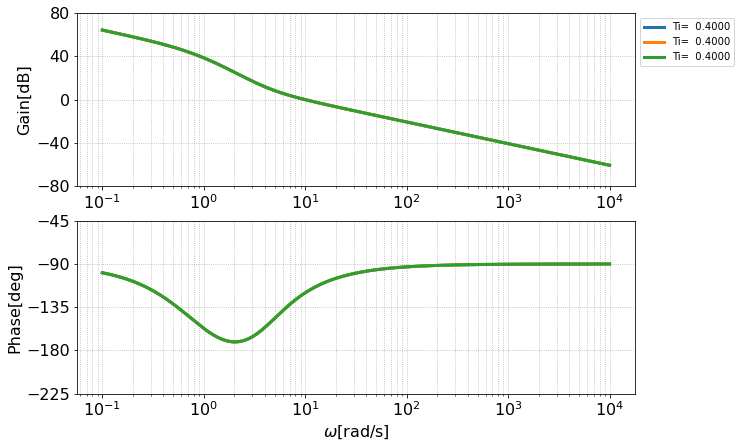

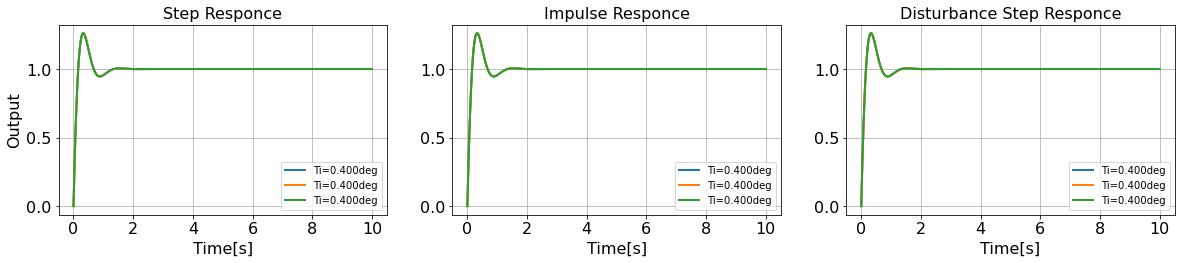

In [164]:
#マルチコプタ角度制御PID制御ゲイン調整（ピッチ角の例）

#https://github.com/kouhei1970/fundamental_of_multicopter_control
import numpy as np
import control.matlab as matlab
import matplotlib.pyplot as plt

#制御対象作成
K=1.0
wn=1.0
zeta=1.0
Plant=matlab.tf([K],[1,2*zeta*wn,wn**2])

print(Plant)

#①位相余裕𝑃𝑀とゲイン交差周波数𝜔_𝑐を決める
PM=60*np.pi/180
omega_c=10

#②位相余裕𝑃𝑀の時の位相 𝜙_𝑚を計算する
phi_m=PM-np.pi

#③制御対象の周波数伝達関数を求める
#pythonではz=1+2*1jの様に複素数が使えます
#角速度制御された角度制御の制御対象の伝達関数
#yaw
#1.86 s^2 + 166.1 s + 1661
#------------------------------------------
#0.0193 s^4 + 2.86 s^3 + 166.1 s^2 + 1661 s

#0.5442 s^2 + 97.17 s + 883.4
#--------------------------------------------
#0.0193 s^4 + 1.544 s^3 + 97.17 s^2 + 883.4 s


def freq_tf(w):
    return (1)\
            /((1j*w)**2 +2*(1j*w)+ 1.0)

Plant_freq=freq_tf(omega_c)

#④制御対象の周波数伝達関数からの𝜔_𝑐の時の実部𝑢の値と虚部𝑣の値を求める
u=Plant_freq.real
v=Plant_freq.imag

#⑤（f）式から比例ゲインを求める
Kp=(u*np.cos(phi_m)+v*np.sin(phi_m))/(u**2+v**2)

#⑥積分時間を適当に決めて（d）式から微分時間を求める

################################

Tis=np.array([0.4, 0.4, 0.4])

################################

Tds=1/omega_c**2/Tis - (v-u*np.tan(phi_m))/omega_c/(u+v*np.tan(phi_m))
#Tds=np.array([10,20,30])
#⑦求めたゲインで周波数応答、ステップ応答、インパルス応答、外乱からの応答等を見る。良くなければ⑥にもどる。良ければ終了
Kps=np.ones(len(Tis))*Kp
print('積分時間はこの範囲で設定してください')
if (v-u*np.tan(phi_m))/omega_c/(u+v*np.tan(phi_m))>0:
    print('0 < Ti < {:f}\n'.format((u+v*np.tan(phi_m))/omega_c/(v-u*np.tan(phi_m))))
else:
    print('Ti>0\n')

fig1=plt.figure(figsize=(10,7))
fig2=plt.figure(figsize=(20,3.5))
ax1=fig1.add_subplot(2,1,1)
ax2=fig1.add_subplot(2,1,2)

ax3=fig2.add_subplot(1,3,1)
ax4=fig2.add_subplot(1,3,2)
ax5=fig2.add_subplot(1,3,3)

for Kp,Ti,Td in zip(Kps, Tis, Tds):    
    Controller=matlab.tf([Kp*Td, Kp, Kp/Ti],[1,0])
    Loop=Plant*Controller
    closesys=matlab.feedback(Loop)

    #位相余裕（ゲイン余裕）
    gm, pm, wpc, wgc=matlab.margin(Loop)
    print('Kp={:8.4f}'.format(Kp))
    print('Ti={:8.4f}'.format(Ti))
    print('Td={:8.4f}'.format(Td))

    print('Gain crossover frequency={:6.2f}rad/s'.format(wgc))
    print('Phase margin={:6.2f}deg\n'.format(pm))

    wfreq=np.logspace(-1,4,1000)

    #開ループボード線図
    magq,phaseq,omegaq = matlab.bode(Loop,wfreq,plot=False)
    ax1.semilogx(omegaq,20*np.log10(magq), lw=3,label='Ti={:8.4f}'.format(Ti))
    #ax1.semilogx(wgc,20*np.log10(1),marker='o')
    ax2.semilogx(omegaq,phaseq*180/np.pi,lw=3,label='Ti={:8.4f}'.format(Ti))
    #ax2.semilogx(wgc,pm-180,marker='o')

    #ステップ応答
    t=np.linspace(0,10,1000)
    y,t=matlab.step(closesys, t)
    ax3.plot(t,y,lw=2,label='Ti={:5.3f}deg'.format(Ti))

    #インパルス応答
    #y,t=matlab.impulse(closesys, t)
    ax4.plot(t,y,lw=2,label='Ti={:5.3f}deg'.format(Ti))

    ###外乱応答
    t=np.linspace(0,10,1000)    
    sys_dist=Plant/(1+Plant*Controller)#sysq_pid/(1+cont_ang*sysq_pid)
    #外乱ステップ応答
    #y,t=matlab.step(sys_dist, t)
    ax5.plot(t,y,lw=2,label='Ti={:5.3f}deg'.format(Ti))

#plt.rcParams["font.size"] = 12
bodefontsize=16
timeresfontsize=16
    
ax1.grid(which="both",ls=':')
ax1.set_yticks(np.arange(-80,81,40))
ax1.set_ylabel('Gain[dB]', fontsize=bodefontsize)
ax1.tick_params(axis='x', labelsize=bodefontsize)
ax1.tick_params(axis='y', labelsize=bodefontsize)

ax2.grid(which="both",ls=':')
#ax2.set_ylim(-200,-70)
ax2.set_yticks([-180-45,-180,-135,-90,-45])
ax2.set_ylabel('Phase[deg]', fontsize=bodefontsize)
ax2.set_xlabel('$\omega$[rad/s]', fontsize=bodefontsize)
ax2.tick_params(axis='x', labelsize=bodefontsize)
ax2.tick_params(axis='y', labelsize=bodefontsize)

ax3.grid()
ax3.tick_params(axis='x', labelsize=timeresfontsize)
ax3.tick_params(axis='y', labelsize=timeresfontsize)
ax3.set_xlabel('Time[s]',fontsize=timeresfontsize)
ax3.set_ylabel('Output',fontsize=timeresfontsize)
ax3.set_title('Step Responce',fontsize=timeresfontsize)

ax4.grid()
ax4.tick_params(axis='x', labelsize=timeresfontsize)
ax4.tick_params(axis='y', labelsize=timeresfontsize)
ax4.set_xlabel('Time[s]',fontsize=timeresfontsize)
ax4.set_title('Impulse Responce',fontsize=timeresfontsize)

ax5.grid()
ax5.tick_params(axis='x', labelsize=timeresfontsize)
ax5.tick_params(axis='y', labelsize=timeresfontsize)
ax5.set_xlabel('Time[s]',fontsize=timeresfontsize)
ax5.set_title('Disturbance Step Responce',fontsize=timeresfontsize)

ax1.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
ax3.legend()
ax4.legend()
ax5.legend()

plt.show()


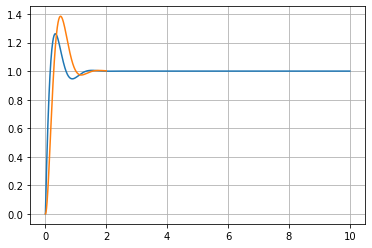

In [167]:
plt.plot(t,y)
plt.plot(T,X)
plt.grid()
plt.show()